In [133]:
import scipy.io
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import os
from SWE_utils_cupy_pipelined import *
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *

In [134]:
# Clear GPU memory
fft_plan_cache = cp.fft.config.get_plan_cache()
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()  

fft_plan_cache.clear()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

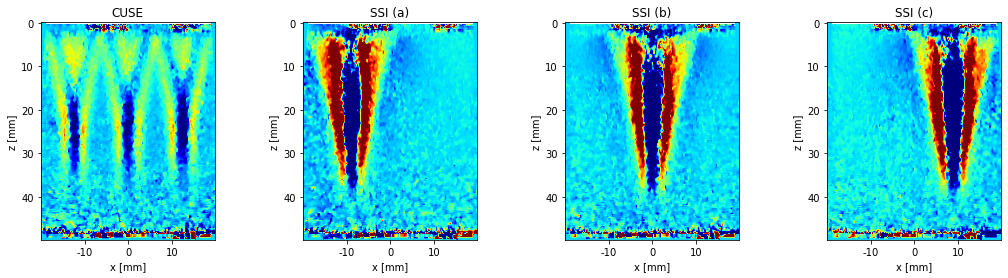

In [136]:
# Display first frame from shear wave motion
ddata1  = sp.io.loadmat("./Parametric_tests/Test_11/swd_pblen200.0_hv40_id_3.mat")
ddata1 = ddata1["data"]
ddata2a = sp.io.loadmat("./Parametric_tests/Test_11/swd_pblen200.0_hv60_id_0.mat")
ddata2a= ddata2a["data"]
ddata2b = sp.io.loadmat("./Parametric_tests/Test_11/swd_pblen200.0_hv60_id_1.mat")
ddata2b= ddata2b["data"]
ddata2c = sp.io.loadmat("./Parametric_tests/Test_11/swd_pblen200.0_hv60_id_2.mat")
ddata2c= ddata2c["data"]

Vrange=[-1.5e-3, 3e-3]
ddata1 = np.clip(ddata1, Vrange[0], Vrange[1])
ddata2a = np.clip(ddata2a, Vrange[0], Vrange[1])
ddata2b = np.clip(ddata2b, Vrange[0], Vrange[1])
ddata2c = np.clip(ddata2c, Vrange[0], Vrange[1])

norm = plt.Normalize(Vrange[0], Vrange[1], True)
ax = [0]*4
fig, ax = plt.subplots(1, 4, figsize=(18, 4))

ax[0].imshow(ddata1[:, :, 0], cmap='jet', norm=norm)
ax[0].set_title('CUSE')
ax[1].imshow(ddata2a[:, :, 0], cmap='jet', norm=norm)
ax[1].set_title('SSI (a)')
ax[2].imshow(ddata2b[:, :, 0], cmap='jet', norm=norm)
ax[2].set_title('SSI (b)')
ax[3].imshow(ddata2c[:, :, 0], cmap='jet', norm=norm)
ax[3].set_title('SSI (c)')

# Assign ticks
sws_dim = ddata1.shape
y_grid = 10
x_grid = 10
grid_step = 0.2

yticks  = np.arange(0, sws_dim[0]-1, int(np.ceil(y_grid / grid_step))) 
yticks_labels = yticks * grid_step
yticks_labels = [str(int(x)) for x in yticks_labels]

m = int(sws_dim[1]//2)
a = np.arange(m, 0, -int(np.ceil(x_grid / grid_step)))
b = np.arange(m, sws_dim[1]-1, int(np.ceil(x_grid / grid_step)))
xticks = np.concatenate((a[1:], b))
xticks_labels = (xticks - m) * grid_step
xticks_labels = [str(int(x)) for x in xticks_labels]

for i in range(4):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticks_labels) 
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(yticks_labels)
    ax[i].set_xlabel('x [mm]')
    ax[i].set_ylabel('z [mm]')




## SWS data compounding CUSE

In [138]:
data = sp.io.loadmat("./Parametric_tests/Test_11/sws_pblen200.0_hv40_id_3.mat")
d = data["data"]

Text(0.5, 1.0, 'r_RL')

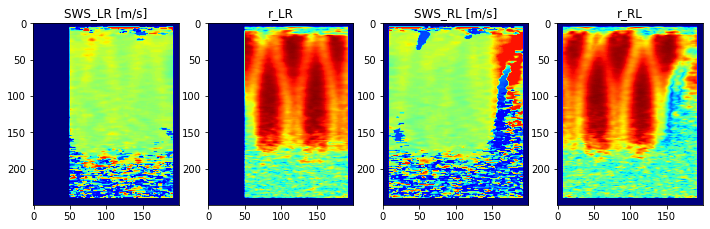

In [139]:
#Visualize the results (pre-compounding)
d_sws = np.squeeze(d[0, ...])
d_r = np.squeeze(d[1, ...])

norm_sws = plt.Normalize(0, 4.5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 8))
##
axs[0].imshow(np.squeeze(d_sws[0,:,:]), cmap='jet', norm=norm_sws)
axs[0].set_title('SWS_LR [m/s]')

axs[1].imshow(np.squeeze(d_r[0,:,:]), cmap='jet', norm=norm_r)
axs[1].set_title('r_LR')

axs[2].imshow(np.squeeze(d_sws[1,:,:]), cmap='jet', norm=norm_sws)
axs[2].set_title('SWS_RL [m/s]')

axs[3].imshow(np.squeeze(d_r[1,:,:]), cmap='jet', norm=norm_r)
axs[3].set_title('r_RL')


In [140]:
# Compounding masks
d_r[1, :, 130:] = 0


In [141]:
# Compound
# Weighted average
SWScr = np.squeeze(np.sum(d_r, axis=0))
SWScr[SWScr==0] = 10e-6

SWSc = d_sws * d_r
SWSc = np.squeeze(np.sum(SWSc, axis=0))
SWSc = SWSc / SWScr

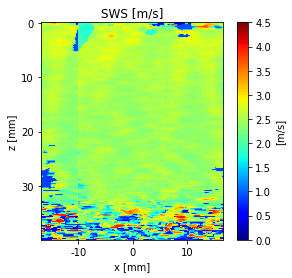

In [142]:
#Visualize the results (post-compounding)
sws_range = [0.5, 4.0]
norm_sws = plt.Normalize(0, 4.5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
pcm = axs.imshow(np.squeeze(SWSc[10:210, 16:-16]), cmap='jet', norm=norm_sws)
axs.set_title('SWS [m/s]')

# Crop
SWSc1 = SWSc[10:210, 16:-16]

# Assign ticks
sws_dim = SWSc1.shape
y_grid = 10
x_grid = 10
grid_step = 0.2

yticks  = np.arange(0, sws_dim[0]-1, int(np.ceil(y_grid / grid_step))) 
yticks_labels = yticks * grid_step
yticks_labels = [str(int(x)) for x in yticks_labels]

m = int(sws_dim[1]//2)
a = np.arange(m, 0, -int(np.ceil(x_grid / grid_step)))
b = np.arange(m, sws_dim[1]-1, int(np.ceil(x_grid / grid_step)))
xticks = np.concatenate((a[1:], b))
xticks_labels = (xticks - m) * grid_step
xticks_labels = [str(int(x)) for x in xticks_labels]

axs.set_xlabel('x [mm]')
axs.set_ylabel('z [mm]')

axs.set_xticks(xticks)
axs.set_xticklabels(xticks_labels) 
axs.set_yticks(yticks)
axs.set_yticklabels(yticks_labels)

fig.colorbar(pcm, ax=axs, label='[m/s]')



In [143]:
#Metrics
mdata = SWSc1[50:150, 50:150]
avgSWS = np.mean(mdata)
print(avgSWS)
stdDev = np.std(mdata)
print(stdDev)

2.440926
0.07994503


## SWS data compounding SSI

In [128]:
data1 = sp.io.loadmat("./Parametric_tests/Test_11/sws_pblen200.0_hv60_id_0.mat")
data2 = sp.io.loadmat("./Parametric_tests/Test_11/sws_pblen200.0_hv60_id_1.mat")
data3 = sp.io.loadmat("./Parametric_tests/Test_11/sws_pblen200.0_hv60_id_2.mat")
d1 = data1["data"]
d2 = data2["data"]
d3 = data3["data"]


Text(0.5, 1.0, 'r_RL')

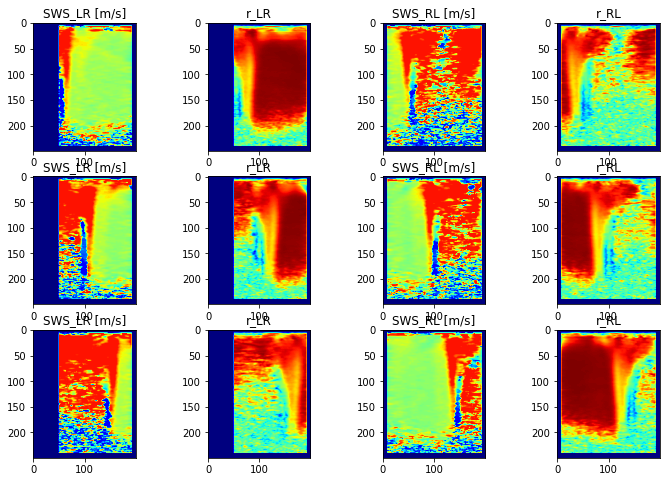

In [129]:
#Visualize the results (pre-compounding)
d1_sws = np.squeeze(d1[0, ...])
d1_r = np.squeeze(d1[1, ...])

d2_sws = np.squeeze(d2[0, ...])
d2_r = np.squeeze(d2[1, ...])

d3_sws = np.squeeze(d3[0, ...])
d3_r = np.squeeze(d3[1, ...])

norm_sws = plt.Normalize(0, 4.5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
##
axs[0,0].imshow(np.squeeze(d1_sws[0,:,:]), cmap='jet', norm=norm_sws)
axs[0,0].set_title('SWS_LR [m/s]')

axs[0,1].imshow(np.squeeze(d1_r[0,:,:]), cmap='jet', norm=norm_r)
axs[0,1].set_title('r_LR')

axs[0,2].imshow(np.squeeze(d1_sws[1,:,:]), cmap='jet', norm=norm_sws)
axs[0,2].set_title('SWS_RL [m/s]')

axs[0,3].imshow(np.squeeze(d1_r[1,:,:]), cmap='jet', norm=norm_r)
axs[0,3].set_title('r_RL')

##
axs[1,0].imshow(np.squeeze(d2_sws[0,:,:]), cmap='jet', norm=norm_sws)
axs[1,0].set_title('SWS_LR [m/s]')

axs[1,1].imshow(np.squeeze(d2_r[0,:,:]), cmap='jet', norm=norm_r)
axs[1,1].set_title('r_LR')

axs[1,2].imshow(np.squeeze(d2_sws[1,:,:]), cmap='jet', norm=norm_sws)
axs[1,2].set_title('SWS_RL [m/s]')

axs[1,3].imshow(np.squeeze(d2_r[1,:,:]), cmap='jet', norm=norm_r)
axs[1,3].set_title('r_RL')

##
axs[2,0].imshow(np.squeeze(d3_sws[0,:,:]), cmap='jet', norm=norm_sws)
axs[2,0].set_title('SWS_LR [m/s]')

axs[2,1].imshow(np.squeeze(d3_r[0,:,:]), cmap='jet', norm=norm_r)
axs[2,1].set_title('r_LR')

axs[2,2].imshow(np.squeeze(d3_sws[1,:,:]), cmap='jet', norm=norm_sws)
axs[2,2].set_title('SWS_RL [m/s]')

axs[2,3].imshow(np.squeeze(d3_r[1,:,:]), cmap='jet', norm=norm_r)
axs[2,3].set_title('r_RL')

In [130]:
# Compounding masks
d1_r[0, :, :80] = 0
d1_r[1, :, :] = 0
d2_r[0, :, :150] = 0
d2_r[1, :, 60:] = 0
d3_r[0, :, :] = 0
d3_r[1, :, 110:] = 0

In [131]:
# Compound
# Weighted average
SWScr = d1_r + d2_r + d3_r
SWScr = np.squeeze(np.sum(SWScr, axis=0))
SWScr[SWScr==0] = 10e-6

SWSc = d1_sws * d1_r + d2_sws * d2_r + d3_sws * d3_r
SWSc = np.squeeze(np.sum(SWSc, axis=0))
SWSc = SWSc / SWScr


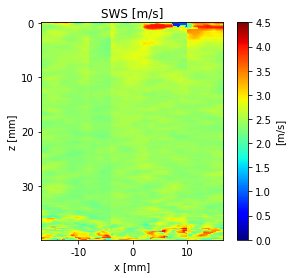

In [132]:
#Visualize the results (post-compounding)
sws_range = [0.5, 4.0]
norm_sws = plt.Normalize(0, 4.5, True)
norm_r   = plt.Normalize(0, 1, True)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
pcm = axs.imshow(np.squeeze(SWSc[10:210, 16:-16]), cmap='jet', norm=norm_sws)
axs.set_title('SWS [m/s]')

# Crop
SWSc1 = SWSc[10:210, 16:-16]

# Assign ticks
sws_dim = SWSc1.shape
y_grid = 10
x_grid = 10
grid_step = 0.2

yticks  = np.arange(0, sws_dim[0]-1, int(np.ceil(y_grid / grid_step))) 
yticks_labels = yticks * grid_step
yticks_labels = [str(int(x)) for x in yticks_labels]

m = int(sws_dim[1]//2)
a = np.arange(m, 0, -int(np.ceil(x_grid / grid_step)))
b = np.arange(m, sws_dim[1]-1, int(np.ceil(x_grid / grid_step)))
xticks = np.concatenate((a[1:], b))
xticks_labels = (xticks - m) * grid_step
xticks_labels = [str(int(x)) for x in xticks_labels]

axs.set_xlabel('x [mm]')
axs.set_ylabel('z [mm]')

axs.set_xticks(xticks)
axs.set_xticklabels(xticks_labels) 
axs.set_yticks(yticks)
axs.set_yticklabels(yticks_labels)

fig.colorbar(pcm, ax=axs, label='[m/s]')

In [137]:
#Metrics
mdata = SWSc1[50:150, 50:150]
avgSWS = np.mean(mdata)
print(avgSWS)
stdDev = np.std(mdata)
print(stdDev)


2.427455
0.071104385
